### A few initial libraries ###

In [1]:
import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
from qiskit.test.mock import FakeManhattan
from qiskit.test.mock import FakeBogota
from qiskit.test.mock import FakeMumbai
from qiskit.test.mock import FakeTokyo
from gate_variants.cx_variants import CX_Variant_Gate 
from orientation_map import orientation_map_gen

In [2]:
qiskit.__qiskit_version__

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.18.1', 'qiskit-aqua': '0.9.5', 'qiskit': '0.32.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

### Load device and the device configuration object ###

In [3]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q-ornl')
# device = FakeMumbai()

# backend_prop = device.properties()

In [4]:
from qiskit_superstaq.superstaq_provider import SuperstaQProvider

In [5]:
superstaq_provider = SuperstaQProvider(api_key="ya29.A0ARrdaM-BWPjpkjhKgbVSRwWROaVE3g6mKCew2all4yXuPNLIwc6l65K10DiAMa-w8he0mR-i0Tb_jE6-GqqWlscj9Zq58rC2oSSzRVaLdZJMoy2bWqIXVhK3Tehp5N4zd8uHhyp01G9KC90Xmu3BKALiGiLP-w")

In [6]:
from level3_context import _parse_transpile_args
from level3_context_pulse import level_3_pass_manager, level_3_context_pulse_pass_manager, level_3_pulse_pass_manager

In [8]:
#benchmark is copied from https://github.com/jmbaker94/quantumcircuitbenchmarks/tree/master/quantumcircuitbenchmarks
#CNX is the same as multi-controlled toffoli
def cnx_halfdirty(circuit, controls, target, ancilla):
    if len(controls) == 2:
        circuit.toffoli(controls[0], controls[1], target)
    elif len(controls) == 1:
        circuit.cx(controls[0], target)
    else:
        bits = []
        bits.append(controls[0])
        
        for i in range(1, len(controls) - 1):
            bits.append(controls[i])
            bits.append(ancilla[i-1])
        bits.append(controls[-1])
        bits.append(target)
        
        for i in range(len(bits) - 1, 0, -2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])
        
        for i in range(4, len(bits) - 2, 2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])
            
        for i in range(len(bits) - 1, 0, -2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])
            
        for i in range(4, len(bits) - 2, 2):
            circuit.toffoli(bits[i-2], bits[i-1], bits[i])

def generate_cnx_halfdirty(n):
    c = qiskit.circuit.QuantumCircuit(n)
    
    qs = range(n)
    
    assert (n + 3) % 2 == 0
    
    reg_len = int((n + 3)  / 2)
    cnx_halfdirty(c, qs[:reg_len -1], qs[reg_len -1], qs[reg_len:])
    return c

In [91]:
t5 = generate_cnx_halfdirty(5)

In [92]:
t5.draw()

q_0: ───────■─────────■──
            │         │  
q_1: ───────■─────────■──
            │         │  
q_2: ──■────┼────■────┼──
     ┌─┴─┐  │  ┌─┴─┐  │  
q_3: ┤ X ├──┼──┤ X ├──┼──
     └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐
q_4: ──■──┤ X ├──■──┤ X ├
          └───┘     └───┘

In [93]:
backend = provider.get_backend('ibmq_jakarta')

In [94]:
backend

<IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-ornl', group='anl', project='csc430')>

In [95]:
backend_prop = backend.properties()

In [96]:
orientation_map = orientation_map_gen(backend)

In [97]:
transpile_args = _parse_transpile_args([t5], backend, seed_transpiler = 0, orientation_map = orientation_map)

In [98]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [99]:
print(pass_manager_config.orientation_map)

{(0, 1): 'f', (1, 0): 'b', (1, 2): 'b', (1, 3): 'f', (2, 1): 'f', (3, 1): 'b', (3, 5): 'f', (4, 5): 'b', (5, 3): 'b', (5, 4): 'f', (5, 6): 'b', (6, 5): 'f'}


In [100]:
pm_context = level_3_pulse_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [101]:
pm_orign = level_3_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [102]:
t_circ = pm_context.run(t5)

ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(5, 'q'), 0),
3: Qubit(QuantumRegister(5, 'q'), 1),
2: Qubit(QuantumRegister(5, 'q'), 2),
1: Qubit(QuantumRegister(5, 'q'), 3),
0: Qubit(QuantumRegister(5, 'q'), 4)
})
intersect [Qubit(QuantumRegister(7, 'q'), 0), Qubit(QuantumRegister(7, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(7, 'q'), 1)]
intersect [Qubit(QuantumRegister(7, 'q'), 1)]
intersect [Qubit(QuantumRegister(7, 'q'), 0), Qubit(QuantumRegister(7, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(7, 'q'), 0), Qubit(QuantumRegister(7, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(7, 'q'), 5), Qubit(QuantumRegister(7, 'q'), 3)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(7, 'q'), 3)]
intersect [Qubit(QuantumRegister(7, 'q'), 3)]
intersect [Qubit(QuantumRegister(7, 'q'), 5), Qubit(QuantumRegister(7, 'q'), 3)]
('00', '1

In [103]:
t_orign = pm_orign.run(t5)

ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(5, 'q'), 0),
3: Qubit(QuantumRegister(5, 'q'), 1),
2: Qubit(QuantumRegister(5, 'q'), 2),
1: Qubit(QuantumRegister(5, 'q'), 3),
0: Qubit(QuantumRegister(5, 'q'), 4)
})


In [104]:
t_circ.count_ops()

OrderedDict([('rz', 74),
             ('ry', 27),
             ('rx', 27),
             ('acecr_pm', 18),
             ('cx', 17),
             ('sx', 8)])

In [105]:
t_circ.draw()

global phase: 2π
               ┌─────────┐                       ┌───────────┐ ┌───────┐  »
      q_4 -> 0 ┤ Rz(π/4) ├───────────────────────┤0          ├─┤ Ry(π) ├──»
               ├─────────┤   ┌────┐  ┌──────────┐│  Acecr_pm │┌┴───────┴─┐»
      q_3 -> 1 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(3π/4) ├┤1          ├┤ Rx(-π/2) ├»
               ├─────────┤   └────┘  └──────────┘└───────────┘└──────────┘»
      q_2 -> 2 ┤ Rz(π/4) ├────────────────────────────────────────────────»
               ├─────────┤┌─────────┐┌─────────┐ ┌───────────┐┌──────────┐»
      q_1 -> 3 ┤ Rz(π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─┤0          ├┤ Ry(-π/2) ├»
               └─────────┘└─────────┘└─────────┘ │           │└──────────┘»
ancilla_0 -> 4 ──────────────────────────────────┤  Acecr_pm ├────────────»
               ┌─────────┐ ┌───────┐ ┌─────────┐ │           │┌─────────┐ »
      q_0 -> 5 ┤ Rz(π/2) ├─┤ Rz(π) ├─┤ Ry(π/2) ├─┤1          ├┤ Rz(π/2) ├─»
               └─────────┘ └───────┘ └─────────┘ └───────────┘└─────────┘ »
ancilla_1 -> 6 ───────────────────────────────────────────────────────────»
                                                                          »
«               ┌──────────┐┌─────────┐  ┌───────┐  ┌───────────┐     »
«      q_4 -> 0 ┤ Rz(-π/2) ├┤ Rz(π/2) ├──┤ Ry(π) ├──┤0          ├─────»
«               └──────────┘├─────────┤  └───────┘  │  Acecr_pm │     »
«      q_3 -> 1 ─────■──────┤ Rx(π/2) ├─────────────┤1          ├──■──»
«                  ┌─┴─┐    ├─────────┤             └───────────┘┌─┴─┐»
«      q_2 -> 2 ───┤ X ├────┤ Rz(π/4) ├──────────────────────────┤ X ├»
«                  └───┘    └─────────┘                          └───┘»
«      q_1 -> 3 ──────────────────────────────────────────────────────»
«                                                                     »
«ancilla_0 -> 4 ──────────────────────────────────────────────────────»
«               ┌─────────┐ ┌──────────┐┌──────────┐                  »
«      q_0 -> 5 ┤ Rx(π/2) ├─┤ Rx(-π/2) ├┤ Rz(-π/2) ├──────────────────»
«               └─────────┘ └──────────┘└──────────┘                  »
«ancilla_1 -> 6 ──────────────────────────────────────────────────────»
«                                                                     »
«               ┌───────────┐ ┌───────┐  ┌──────────┐┌─────────┐ ┌───────┐  »
«      q_4 -> 0 ┤0          ├─┤ Ry(π) ├──┤ Rz(-π/2) ├┤ Rz(π/2) ├─┤ Ry(π) ├──»
«               │  Acecr_pm │┌┴───────┴─┐├──────────┤└─────────┘┌┴───────┴┐ »
«      q_3 -> 1 ┤1          ├┤ Rx(-π/2) ├┤ Rz(-π/4) ├─────■─────┤ Rx(π/2) ├─»
«               └┬──────────┤└──────────┘└──────────┘   ┌─┴─┐   ├─────────┴┐»
«      q_2 -> 2 ─┤ Rz(-π/4) ├───────────────────────────┤ X ├───┤ Rz(-π/4) ├»
«                └──────────┘                           └───┘   └──────────┘»
«      q_1 -> 3 ────────────────────────────────────────────────────────────»
«                                                                           »
«ancilla_0 -> 4 ────────────────────────────────────────────────────────────»
«                                                                           »
«      q_0 -> 5 ────────────────────────────────────────────────────────────»
«                                                                           »
«ancilla_1 -> 6 ────────────────────────────────────────────────────────────»
«                                                                           »
«               ┌───────────┐                                 ┌───────────┐»
«      q_4 -> 0 ┤0          ├─────────────────────────────────┤0          ├»
«               │  Acecr_pm │     ┌─────────┐┌────┐┌─────────┐│  Acecr_pm │»
«      q_3 -> 1 ┤1          ├──■──┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤1          ├»
«               └───────────┘┌─┴─┐├─────────┤└────┘└─────────┘└───────────┘»
«      q_2 -> 2 ─────────────┤ X ├┤ Rz(π/4) ├──────────────────────────────»
«                            └───┘└─────────┘                              »
«      q_1 -> 3 ──────────────────────────────────────

In [107]:
out = superstaq_provider.ibmq_compile(t_circ, target="ibmq_jakarta_qpu")

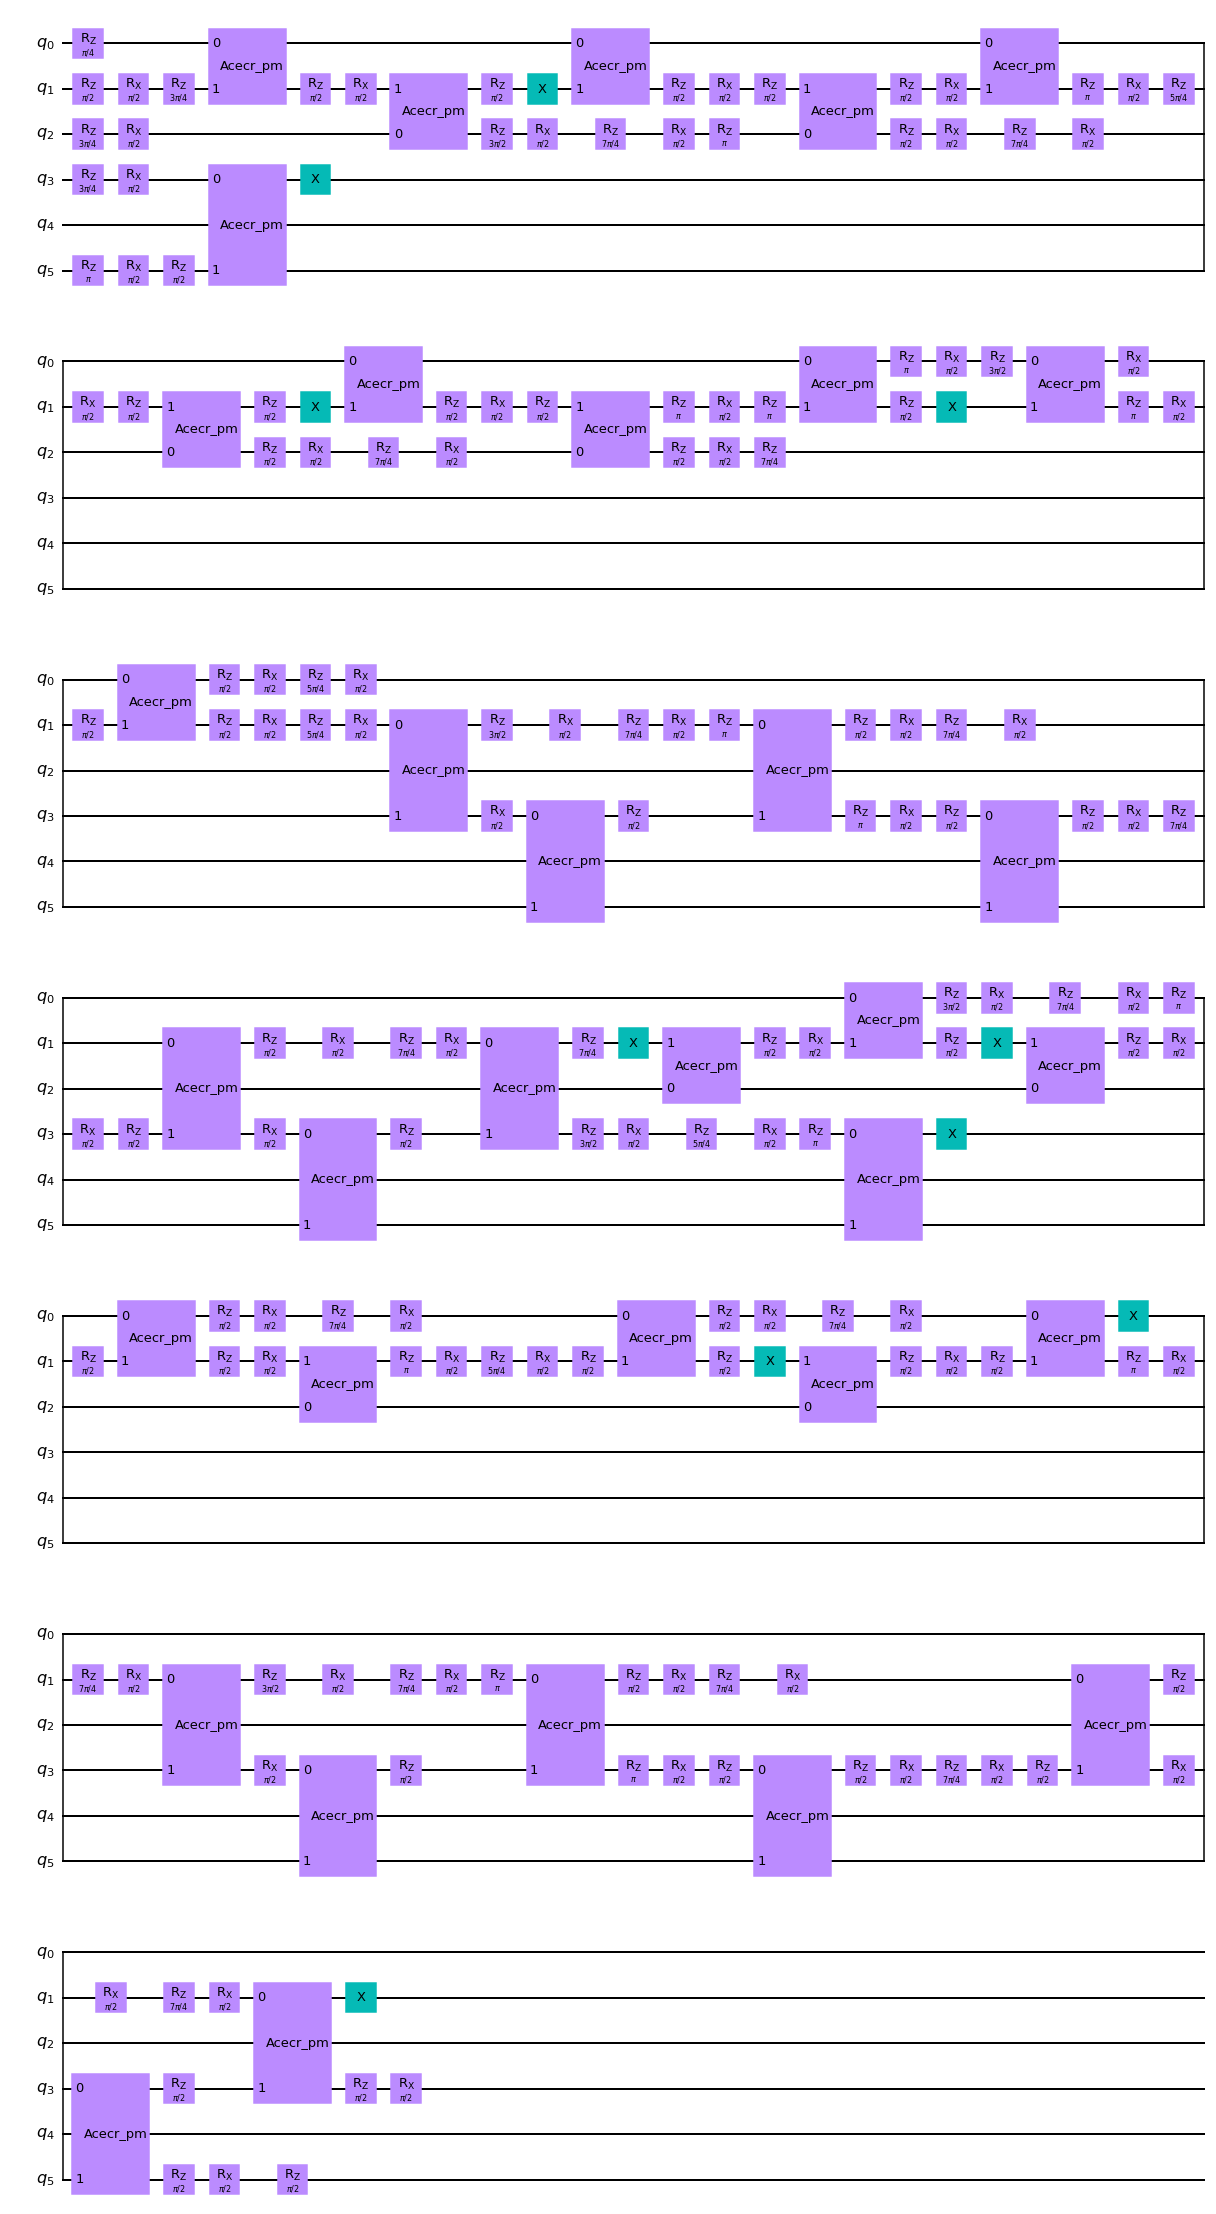

In [108]:
out.circuit.draw(output='mpl')

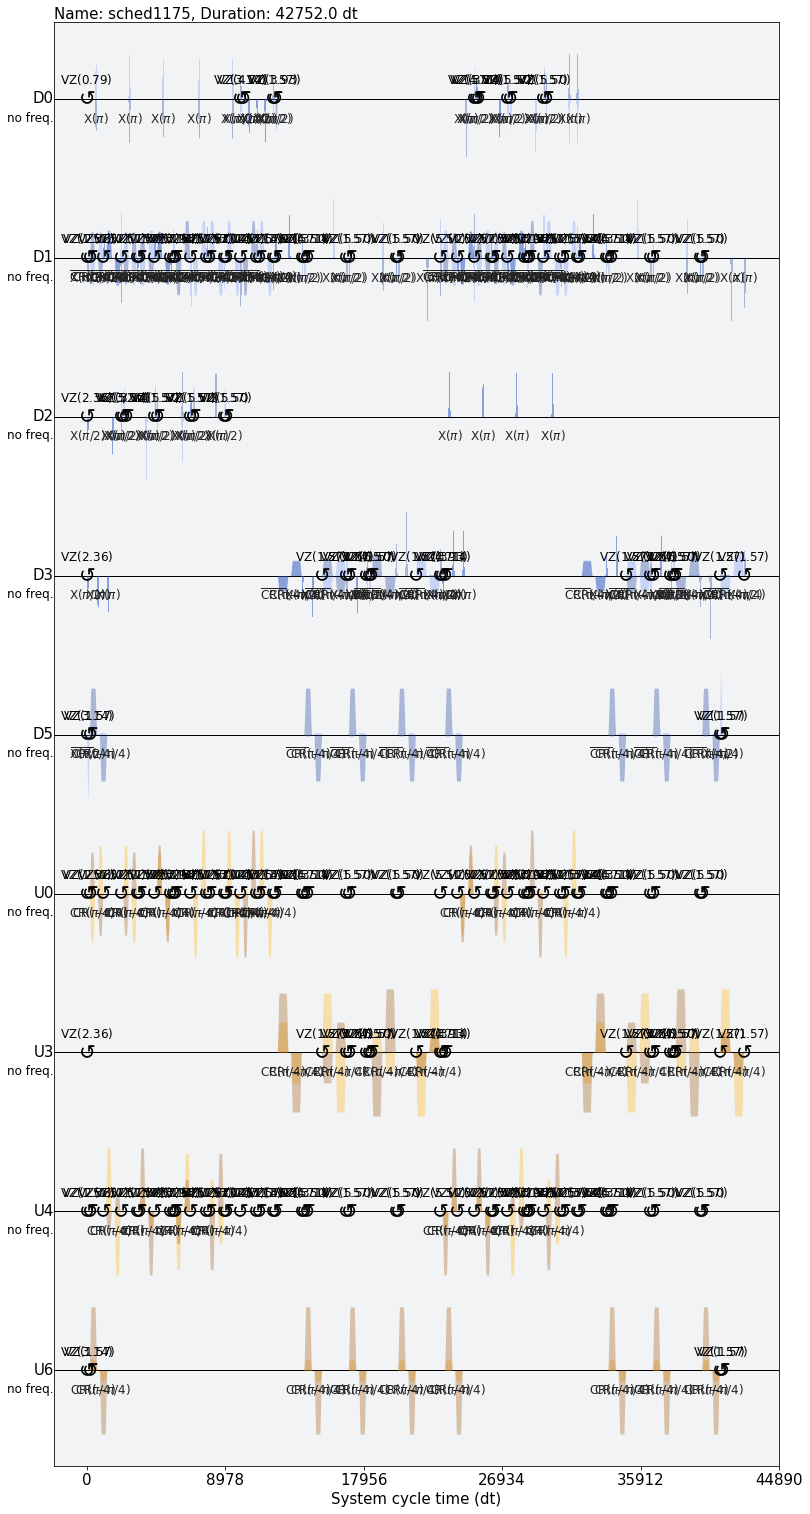

In [109]:
out.pulse_sequence.draw()

In [110]:
out.circuit.count_ops()

OrderedDict([('rz', 93), ('rx', 65), ('acecr_pm', 35), ('x', 10)])

In [111]:
out2 = superstaq_provider.ibmq_compile(t_orign, target="ibmq_jakarta_qpu")

In [112]:
out2.circuit.count_ops()

OrderedDict([('rz', 118), ('rx', 69), ('acecr_pm', 35), ('x', 23)])

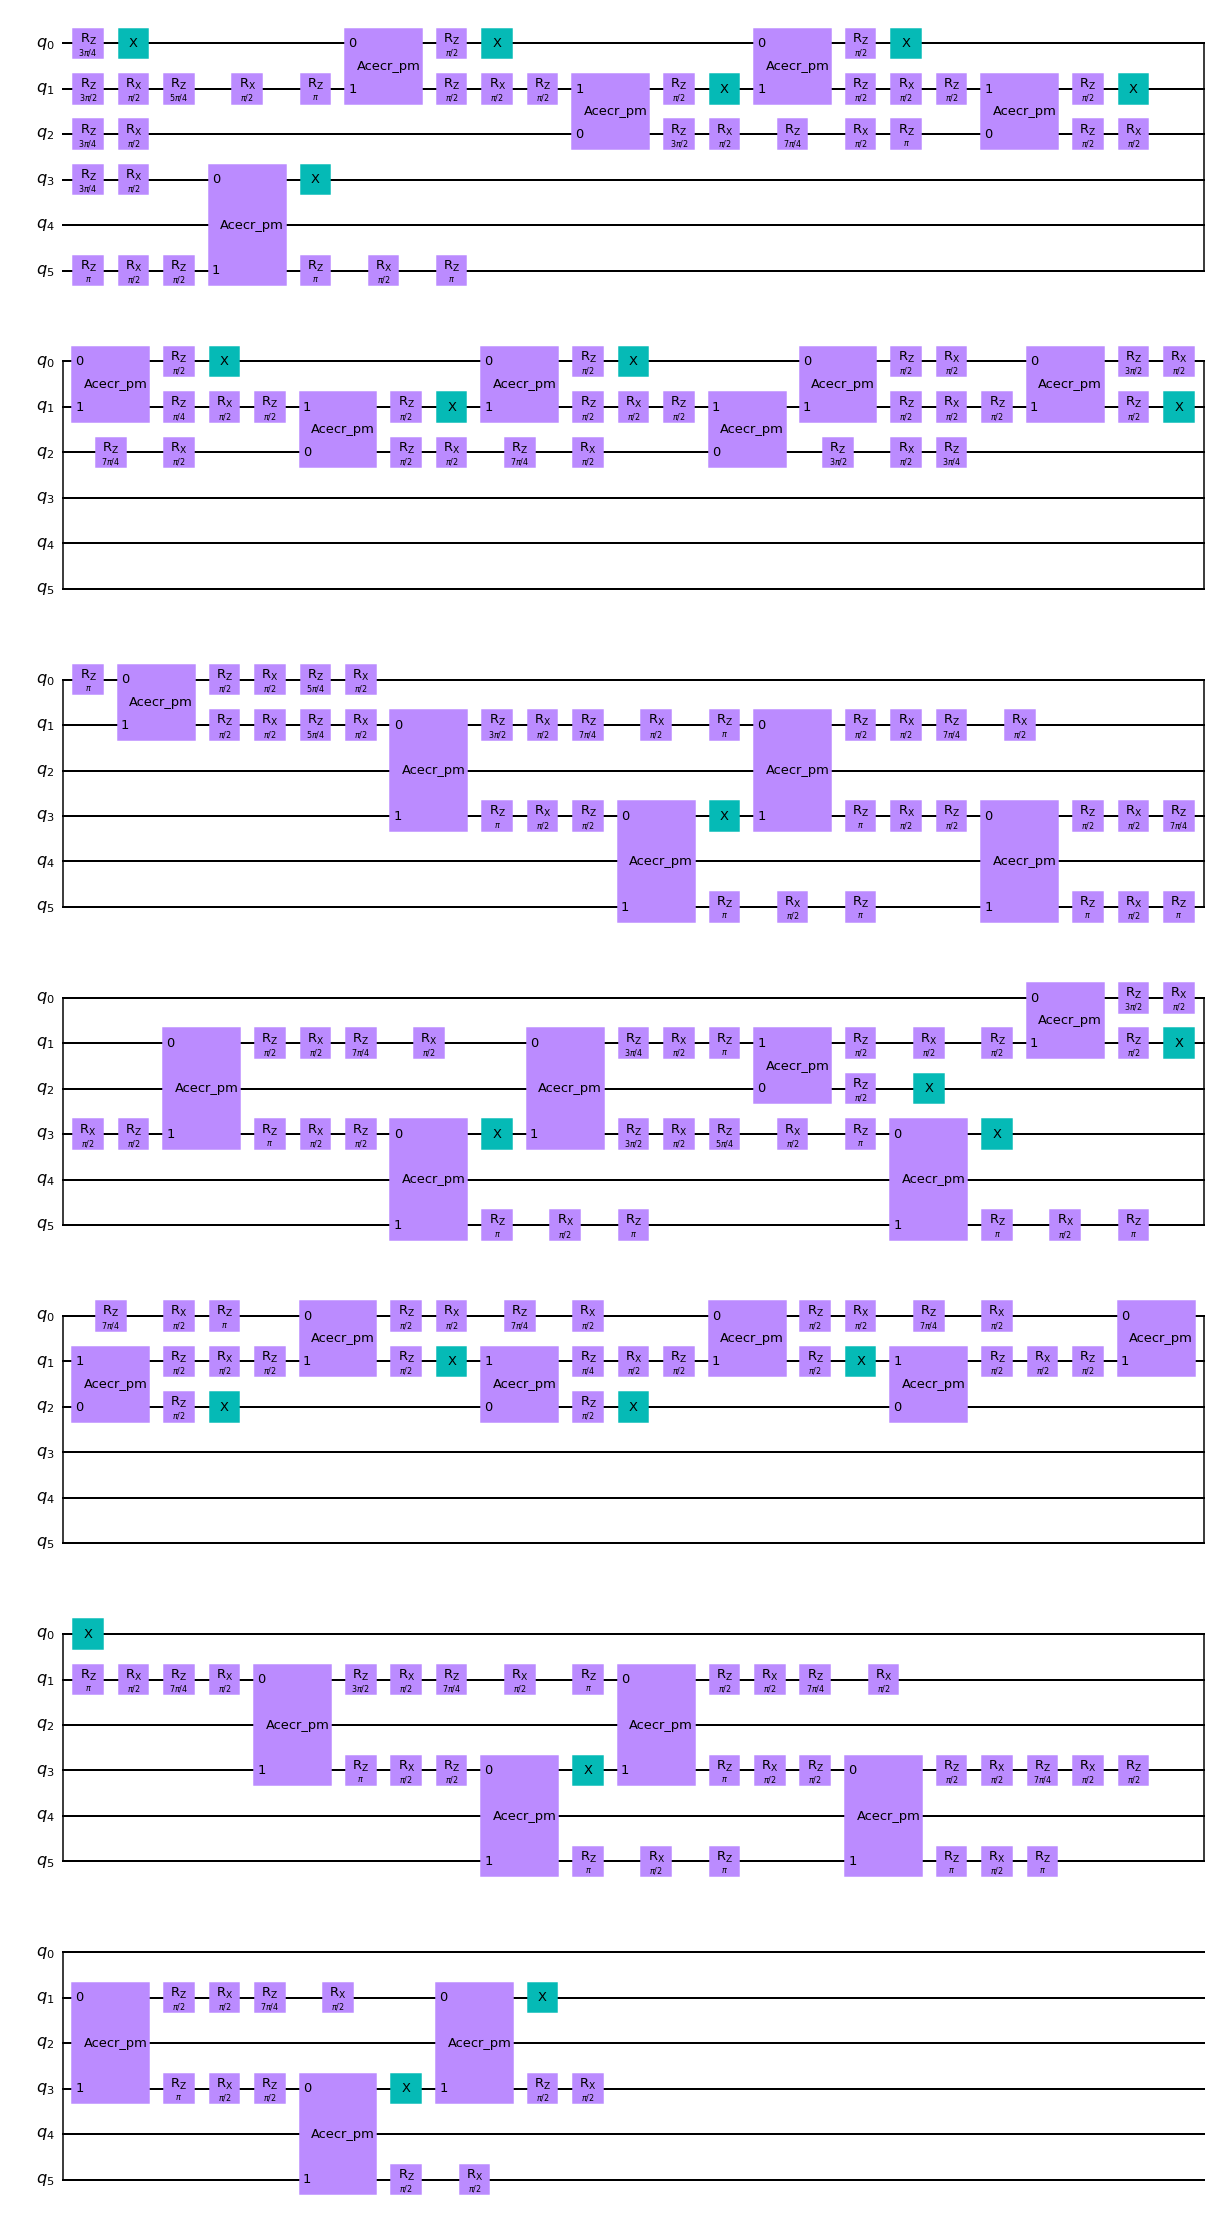

In [113]:
out2.circuit.draw(output='mpl')

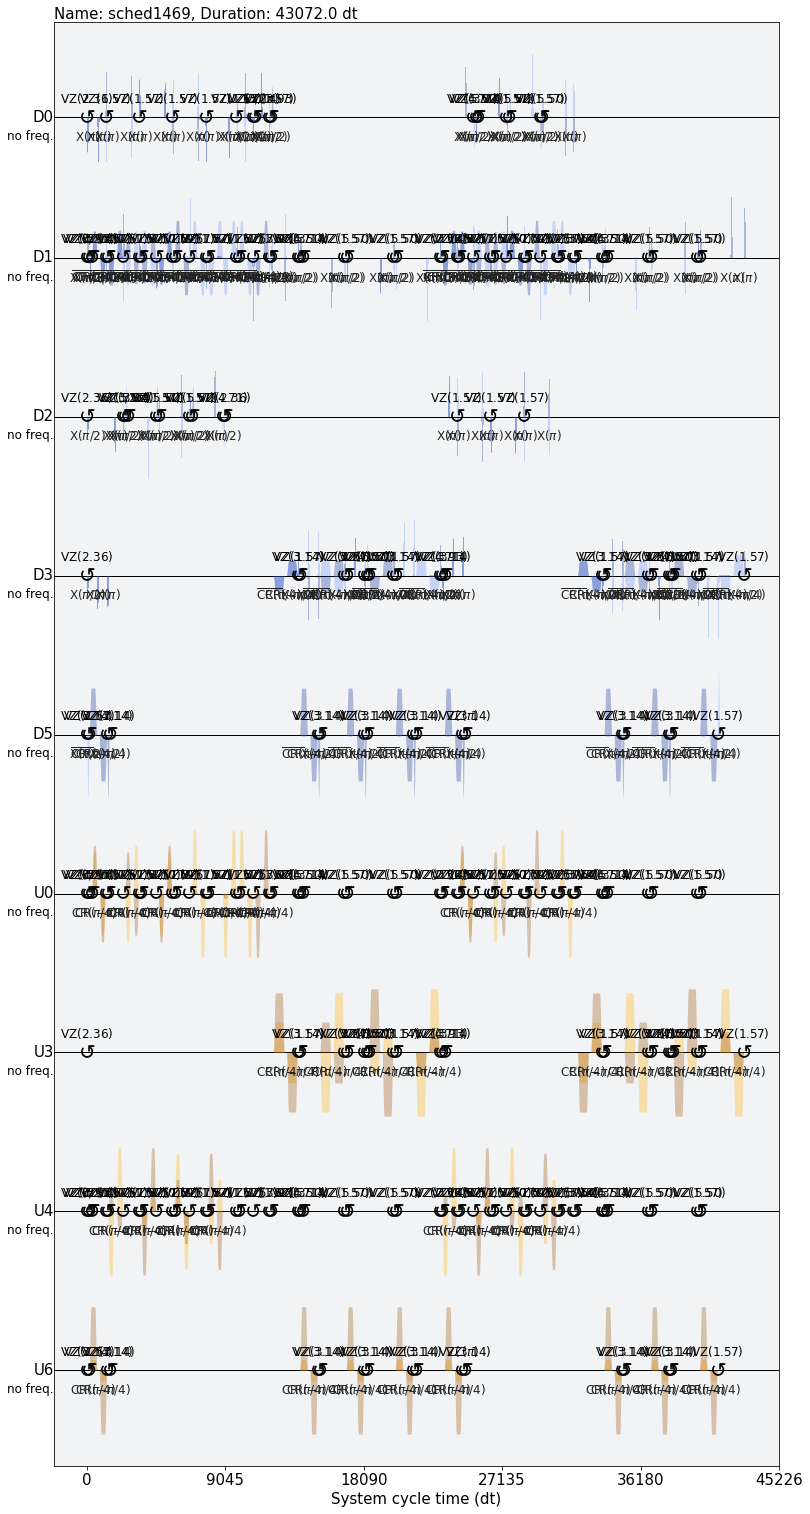

In [116]:
out2.pulse_sequence.draw()

In [114]:
t_orign = transpile(t5, backend, optimization_level = 3)

In [28]:
t_orign_schedule = schedule(
            circuits=t_orign,
            backend=backend,
            inst_map=None,
            meas_map=None,
            method=None,
        )

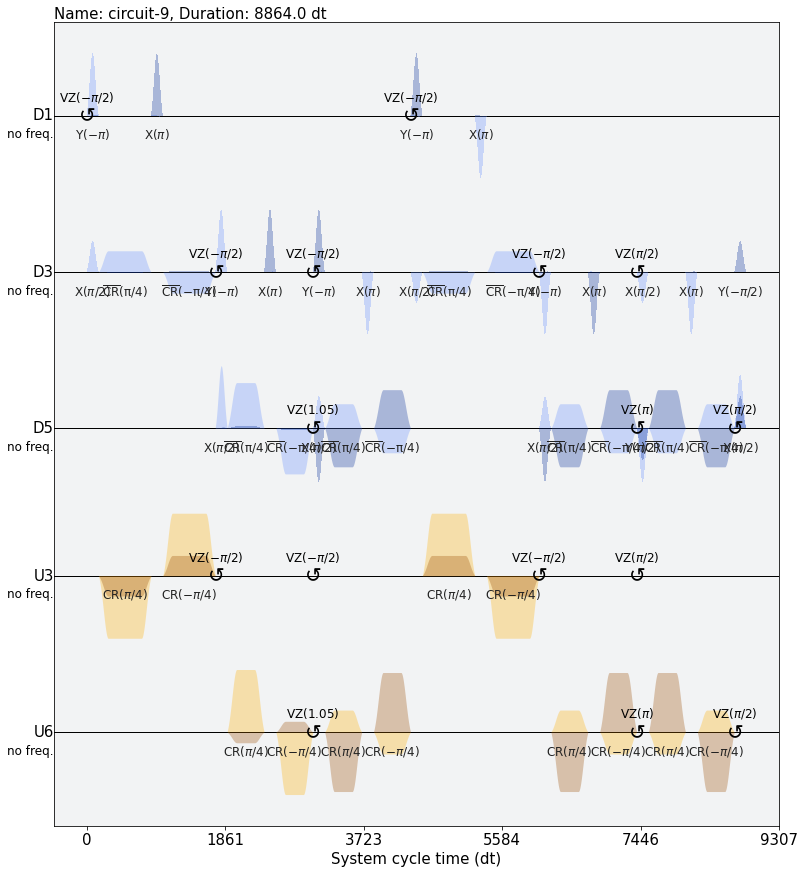

In [29]:
t_orign_schedule.draw()

In [30]:
#19

In [31]:
t_orign_schedule.children[5]

(6080,
 Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(3))), (0, ShiftPhase(1.5707963267948966, ControlChannel(3))), (0, ShiftPhase(1.5707963267948966, ControlChannel(8))), (0, Play(Drag(duration=160, amp=(-3.554362359433285e-17-0.19349047479964404j), sigma=40, beta=0.557336464289407, name='Ym_d3'), DriveChannel(3), name='Ym_d3')), (0, Play(Drag(duration=160, amp=(0.09343255413184134+0.0013155736420234682j), sigma=40, beta=-0.8260101223075255, name='X90p_d5'), DriveChannel(5), name='X90p_d5')), (160, Play(GaussianSquare(duration=496, amp=(0.06823970936107211+0.0029056778790278004j), sigma=64, width=240, name='CR90p_d5_u6'), DriveChannel(5), name='CR90p_d5_u6')), (160, Play(GaussianSquare(duration=496, amp=(0.4793427847550843-0.08228725735534022j), sigma=64, width=240, name='CR90p_u6'), ControlChannel(6), name='CR90p_u6')), (656, Play(Drag(duration=160, amp=(0.19349047479964404+0j), sigma=40, beta=0.557336464289407, name='Xp_d3'), DriveChannel(3), name='Xp_d3')), (816, Play(Ga

In [32]:
help(t_orign_schedule)

Help on Schedule in module qiskit.pulse.schedule object:

class Schedule(builtins.object)
 |  Schedule(*schedules: Union[ForwardRef('Schedule'), qiskit.pulse.instructions.instruction.Instruction, Tuple[int, Union[ForwardRef('Schedule'), qiskit.pulse.instructions.instruction.Instruction]]], name: Union[str, NoneType] = None, metadata: Union[dict, NoneType] = None)
 |  
 |  A quantum program *schedule* with exact time constraints for its instructions, operating
 |  over all input signal *channels* and supporting special syntaxes for building.
 |  
 |  Pulse program representation for the original Qiskit Pulse model [1].
 |  Instructions are not allowed to overlap in time
 |  on the same channel. This overlap constraint is immediately
 |  evaluated when a new instruction is added to the ``Schedule`` object.
 |  
 |  It is necessary to specify the absolute start time and duration
 |  for each instruction so as to deterministically fix its execution time.
 |  
 |  The ``Schedule`` program s

In [33]:
t_orign_schedule.instructions

((0, ShiftPhase(1.5707963267948966, DriveChannel(1))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(0))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(4))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(5))),
 (0,
  Play(Drag(duration=160, amp=(-3.5177580880852906e-17-0.19149783107719934j), sigma=40, beta=-1.0249306744293878, name='Ym_d1'), DriveChannel(1), name='Ym_d1')),
 (0,
  Play(Drag(duration=160, amp=(0.09672086584553752-0.0002442998264774194j), sigma=40, beta=0.5292268605797695, name='X90p_d3'), DriveChannel(3), name='X90p_d3')),
 (160,
  Play(GaussianSquare(duration=704, amp=(0.06553461814337508-0.0017965272209132079j), sigma=64, width=448, name='CR90p_d3_u3'), DriveChannel(3), name='CR90p_d3_u3')),
 (160,
  Play(GaussianSquare(duration=704, amp=(-0.7591395560293808-0.2461181293735626j), sigma=64, width=448, name='CR90p_u3'), ControlChannel(3), name='CR90p_u3')),
 (864,
  Play(Drag(duration=160, amp=(0.19149783107719934+0j), sigma=40, beta=-1.0249306744293878,

In [34]:
t_orign_schedule.instructions[4][-1].name

'Ym_d1'